In [1]:
import os

import matplotlib.pyplot
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import umap
from matplotlib.colors import LogNorm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (adjusted_rand_score, completeness_score,
                             homogeneity_score, mean_absolute_error,
                             normalized_mutual_info_score, r2_score,
                             silhouette_score)
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch.multiprocessing as mp

mp.set_start_method("spawn", force=True)

name = "Huber_C_max"

In [2]:
%load_ext autoreload
%autoreload 2

from utils import *
from VAE_GDSC import GDSCDataset, GeneDrugVAE

In [3]:
cellline = pd.read_csv(
    "../dataset/gdsc/cellline_info.csv.gz",
    usecols=["COSMIC_ID", "SMILES", "NAME", "Z_score"],
)
exp = pd.read_csv("../dataset/gdsc/exp.csv.gz", index_col=0)

In [4]:
# 学習済みモデルの指定（ChemBERTa）
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"

# トークナイザーとモデルをロード
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# GPUが使える場合はGPUに
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
smiles_list = cellline["SMILES"].unique().tolist()

inputs = tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

In [6]:
drugs = pd.DataFrame(embeddings.cpu().numpy())
drugs.index = smiles_list

In [7]:
exp.index = exp.index.astype(str)
cellline["COSMIC_ID"] = cellline["COSMIC_ID"].astype(str)
drugs.index = drugs.index.astype(str)

In [8]:
exp_values = exp.to_numpy(dtype=np.float32)
cid_to_row = {cid: i for i, cid in enumerate(exp.index)}
drug_vec = {s: drugs.loc[s].to_numpy(dtype=np.float32) for s in drugs.index}
mask = cellline["COSMIC_ID"].isin(exp.index) & cellline["SMILES"].isin(drugs.index)
cellline_small = cellline.loc[mask].reset_index(drop=True)
print(f"usable pairs: {len(cellline_small):,} / {len(cellline):,}")

usable pairs: 284,826 / 284,826


In [9]:
print("n_sample:", cellline_small.shape[0])

n_sample: 284826


In [10]:
# そのまま/変更案
batch_size = 16384
num_epochs = 100

# まずはこのセットで様子見（20–30 epoch）
rec_w = 0.2  # 再構成の重みをさらに下げる
lam = 3.0  # 10.0 → 3.0（目安: 2〜5）
beta_max = 1.0  # KLを抑える項は一旦オフ
gamma = 2.0  # C に寄せる圧を強化（いまの4倍）

C_max = 0.07  # 0.10 → 0.05
C_steps = 200  # 100 → 200

lr = 1e-3
weight_decay = 1e-3

In [11]:
ds = GDSCDataset(
    cellline_small,
    exp_values,
    cid_to_row,
    drug_vec,
    dtype=torch.float32,
    pin_memory=True,
    copy_arrays=False,
    #     materialize="none",    # ← これが重要！前展開を完全禁止
    #     ram_limit_gb=0.5       # （任意）auto を使う時の安全枠も小さくできる
)

In [12]:
val_ratio = 0.2
n_total = len(ds)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

# 再現性
g = torch.Generator().manual_seed(42)
train_ds, val_ds = random_split(ds, [n_train, n_val], generator=g)

In [13]:
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,  # GPU メモリに合わせて調整（8k〜32k 目安）
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True,
)

In [14]:
val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,  # 余裕があれば少し大きめ
    shuffle=False,  # 検証はシャッフル不要
    num_workers=1,  # ここは少なめでもOK
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    drop_last=False,
)

In [15]:
gene_dim = exp_values.shape[1]
smiles_dim = 768

device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else (
        torch.device("mps")
        if torch.backends.mps.is_available()
        else torch.device("cpu")
    )
)
device_type = (
    "cuda" if device.type == "cuda" else ("mps" if device.type == "mps" else "cpu")
)

use_amp = device_type in ("cuda", "mps")

# GradScaler は CUDA のみ
scaler = torch.amp.GradScaler(enabled=(device_type == "cuda"))

In [16]:
os.makedirs("models/gdsc", exist_ok=True)

best_val = float("inf")
best_path = f"models/gdsc/gdsc_best_{name}.pt"

# --- logs / histories ---
train_hist, val_hist, elbo_val_hist = [], [], []
train_rec_hist, train_kl_hist, train_z_hist = [], [], []
val_rec_hist, val_kl_hist, val_z_hist = [], [], []
train_capgap_hist, val_capgap_hist, C_values = [], [], []

model = GeneDrugVAE(
    gene_dim, drug_dim=smiles_dim, proj_dim=256, hidden=512, latent=128
).to(device)

# 1) Optimizer を param group で作り直し
head_params = list(model.head.parameters())
base_params = [p for n, p in model.named_parameters() if not n.startswith("head.")]

opt = torch.optim.Adam(
    [
        {"params": base_params, "lr": lr, "weight_decay": 1e-3},
        {"params": head_params, "lr": lr * 0.5, "weight_decay": 5e-3},  # ← LR↓, WD↑
    ]
)


def _avg(sum_val, cnt):
    return sum_val / max(cnt, 1)


beta_warmup_epochs = int(0.5 * num_epochs)
for ep in range(num_epochs):
    # === 追加：このepochのβ（0→1に線形） ===
    beta = beta_max * min(1.0, (ep + 1) / beta_warmup_epochs)

    model.train()
    C = C_max * (ep / C_steps) if ep < C_steps else C_max
    C_values.append(C)

    # ---- training ----
    m_total = n_batches = 0
    rec_sum = kl_sum = z_sum = capgap_sum = 0.0
    n_train_samples = 0

    for bidx, (xg, xd, y) in enumerate(
        tqdm(train_dl, desc=f"Train E{ep+1}", leave=False)
    ):
        if ep == 0 and bidx == 0:
            print(
                f"[LR] base={opt.param_groups[0]['lr']:.2e} | head={opt.param_groups[1]['lr']:.2e}"
            )

        xg = xg.to(device, non_blocking=True)
        xd = xd.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device_type, enabled=use_amp):
            recon, mu, lv, yhat = model(xg, xd)
            rec = F.mse_loss(recon, xg, reduction="mean")
            kl = 0.5 * (-1 - lv + mu.pow(2) + lv.exp()).sum(dim=1).mean()
            zloss = F.smooth_l1_loss(yhat, y, beta=1, reduction="mean")  # Huber
            gap_abs = torch.abs(kl - C)
            gap_sq = (kl - C) ** 2
            loss = rec_w * rec + beta * kl + gamma * gap_sq + lam * zloss

        if device_type == "cuda":
            prev_scale = scaler.get_scale()
            scaler.scale(loss).backward()
            scaler.unscale_(opt)  # ← これを追加してからクリップ
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

        bs = xg.size(0)
        m_total += loss.item()
        n_batches += 1
        rec_sum += rec.item() * bs
        kl_sum += kl.item() * bs
        z_sum += zloss.item() * bs
        capgap_sum += gap_abs.item() * bs
        n_train_samples += bs

    train_loss = m_total / n_batches
    train_hist.append(train_loss)
    train_rec_hist.append(_avg(rec_sum, n_train_samples))
    train_kl_hist.append(_avg(kl_sum, n_train_samples))
    train_z_hist.append(_avg(z_sum, n_train_samples))
    train_capgap_hist.append(_avg(capgap_sum, n_train_samples))

    # ---- validation ----
    model.eval()
    val_loss_sum = 0.0
    n_val_batches = 0
    v_rec_sum = v_kl_sum = v_z_sum = v_capgap_sum = 0.0
    n_val_samples = 0
    elbo_val_sum = 0.0

    with torch.no_grad():
        for xg, xd, y in val_dl:
            xg, xd, y = xg.to(device), xd.to(device), y.to(device)
            recon, mu, lv, yhat = model(xg, xd)
            rec = F.mse_loss(recon, xg, reduction="mean")
            kl = 0.5 * (-1 - lv + mu.pow(2) + lv.exp()).sum(dim=1).mean()
            zloss = F.smooth_l1_loss(yhat, y, beta=1, reduction="mean")  # Huber
            gap_abs = torch.abs(kl - C)  # ← 追加：ログ用
            gap_sq = (kl - C) ** 2  # ← 追加：損失用（二乗）

            loss = rec_w * rec + beta * kl + gamma * gap_sq + lam * zloss
            elbo_loss = rec + beta * kl + lam * zloss

            bs = xg.size(0)
            val_loss_sum += loss.item()
            n_val_batches += 1
            v_rec_sum += rec.item() * bs
            v_kl_sum += kl.item() * bs
            v_z_sum += zloss.item() * bs
            v_capgap_sum += gap_abs.item() * bs  # ← 置換：capgap → gap_abs
            n_val_samples += bs
            elbo_val_sum += elbo_loss.item() * bs

    val_loss = val_loss_sum / n_val_batches
    val_hist.append(val_loss)
    val_rec_hist.append(_avg(v_rec_sum, n_val_samples))
    val_kl_hist.append(_avg(v_kl_sum, n_val_samples))
    val_z_hist.append(_avg(v_z_sum, n_val_samples))
    val_capgap_hist.append(_avg(v_capgap_sum, n_val_samples))
    elbo_val_hist.append(_avg(elbo_val_sum, n_val_samples))

    print(
        f"Epoch {ep+1}/{num_epochs} | Train {train_loss:.4f} | Val {val_loss:.4f} | Val(ELBO) {elbo_val_hist[-1]:.4f}"
    )

    print(
        f"  C={C:.3f} | "
        f"KL tr/val={train_kl_hist[-1]:.4f}/{val_kl_hist[-1]:.4f} | "
        f"gap(|KL-C|) tr/val={train_capgap_hist[-1]:.4f}/{val_capgap_hist[-1]:.4f} | "
        f"zloss tr/val={train_z_hist[-1]:.4f}/{val_z_hist[-1]:.4f} | "
        f"rec tr/val={train_rec_hist[-1]:.4f}/{val_rec_hist[-1]:.4f} | "
        f"beta={beta:.4f}, gamma={gamma:.4f}"
    )

    if (ep + 1) % 10 == 0:
        model.eval()
        eval_dl = torch.utils.data.DataLoader(
            val_ds,
            batch_size=8192,
            shuffle=False,
            num_workers=0,
            pin_memory=False,
            persistent_workers=False,
            drop_last=False,
        )
        ys, yhats = [], []
        with torch.inference_mode():
            for xg, xd, y in eval_dl:
                xg, xd = xg.to(device), xd.to(device)
                _, _, _, yhat = model(xg, xd)
                ys.append(y.cpu().numpy())
                yhats.append(yhat.cpu().numpy())
        import numpy as np
        from sklearn.metrics import mean_absolute_error, r2_score

        ys = np.concatenate(ys)
        yhats = np.concatenate(yhats)
        mae = mean_absolute_error(ys, yhats)
        r2 = r2_score(ys, yhats)
        print(f"  [Eval@E{ep+1}] MAE={mae:.4f}, R^2={r2:.4f}")
        print(f"  [Eval@E{ep+1}] yhat mean/std = {yhats.mean():.4f}/{yhats.std():.4f}")

    if val_loss < best_val - 1e-6:
        best_val = val_loss
        torch.save(model.state_dict(), best_path)
        print(f"[Save] Best model updated at epoch {ep+1}: {best_path}")

Train E1:   0%|          | 0/13 [00:00<?, ?it/s]

[LR] base=1.00e-03 | head=5.00e-04


Epoch 1/100 | Train 1.4489 | Val 1.3920 | Val(ELBO) 2.1942
  C=0.000 | KL tr/val=0.0972/0.0766 | gap(|KL-C|) tr/val=0.0972/0.0766 | zloss tr/val=0.4040/0.3922 | rec tr/val=1.0343/1.0161 | beta=0.0200, gamma=2.0000
[Save] Best model updated at epoch 1: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 2/100 | Train 1.3487 | Val 1.3142 | Val(ELBO) 2.0997
  C=0.000 | KL tr/val=0.0940/0.0954 | gap(|KL-C|) tr/val=0.0937/0.0950 | zloss tr/val=0.3750/0.3639 | rec tr/val=1.0091/1.0041 | beta=0.0400, gamma=2.0000
[Save] Best model updated at epoch 2: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 3/100 | Train 1.2823 | Val 1.2630 | Val(ELBO) 2.0504
  C=0.001 | KL tr/val=0.1021/0.0833 | gap(|KL-C|) tr/val=0.1014/0.0826 | zloss tr/val=0.3517/0.3482 | rec tr/val=1.0019/1.0008 | beta=0.0600, gamma=2.0000
[Save] Best model updated at epoch 3: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 4/100 | Train 1.2371 | Val 1.2320 | Val(ELBO) 2.0157
  C=0.001 | KL tr/val=0.0938/0.0928 | gap(|KL-C|) tr/val=0.0927/0.0918 | zloss tr/val=0.3374/0.3361 | rec tr/val=1.0001/0.9999 | beta=0.0800, gamma=2.0000
[Save] Best model updated at epoch 4: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 5/100 | Train 1.2147 | Val 1.2142 | Val(ELBO) 2.0046
  C=0.001 | KL tr/val=0.0780/0.0700 | gap(|KL-C|) tr/val=0.0766/0.0686 | zloss tr/val=0.3316/0.3326 | rec tr/val=0.9994/0.9997 | beta=0.1000, gamma=2.0000
[Save] Best model updated at epoch 5: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 6/100 | Train 1.1977 | Val 1.1982 | Val(ELBO) 1.9884
  C=0.002 | KL tr/val=0.0687/0.0704 | gap(|KL-C|) tr/val=0.0669/0.0686 | zloss tr/val=0.3268/0.3268 | rec tr/val=0.9998/0.9997 | beta=0.1200, gamma=2.0000
[Save] Best model updated at epoch 6: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 7/100 | Train 1.1794 | Val 1.1813 | Val(ELBO) 1.9757
  C=0.002 | KL tr/val=0.0625/0.0559 | gap(|KL-C|) tr/val=0.0604/0.0538 | zloss tr/val=0.3211/0.3227 | rec tr/val=0.9997/0.9997 | beta=0.1400, gamma=2.0000
[Save] Best model updated at epoch 7: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 8/100 | Train 1.1676 | Val 1.2042 | Val(ELBO) 1.9927
  C=0.002 | KL tr/val=0.0564/0.0777 | gap(|KL-C|) tr/val=0.0539/0.0752 | zloss tr/val=0.3176/0.3269 | rec tr/val=0.9994/0.9997 | beta=0.1600, gamma=2.0000


Epoch 9/100 | Train 1.1711 | Val 1.1689 | Val(ELBO) 1.9623
  C=0.003 | KL tr/val=0.0512/0.0609 | gap(|KL-C|) tr/val=0.0484/0.0581 | zloss tr/val=0.3190/0.3172 | rec tr/val=0.9996/0.9997 | beta=0.1800, gamma=2.0000
[Save] Best model updated at epoch 9: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 10/100 | Train 1.1506 | Val 1.1552 | Val(ELBO) 1.9494
  C=0.003 | KL tr/val=0.0505/0.0585 | gap(|KL-C|) tr/val=0.0474/0.0553 | zloss tr/val=0.3120/0.3127 | rec tr/val=0.9998/0.9997 | beta=0.2000, gamma=2.0000
  [Eval@E10] MAE=0.6558, R^2=0.2637
  [Eval@E10] yhat mean/std = 0.0643/0.5137
[Save] Best model updated at epoch 10: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 11/100 | Train 1.1367 | Val 1.1583 | Val(ELBO) 1.9542
  C=0.004 | KL tr/val=0.0482/0.0494 | gap(|KL-C|) tr/val=0.0447/0.0459 | zloss tr/val=0.3074/0.3145 | rec tr/val=0.9995/0.9997 | beta=0.2200, gamma=2.0000


Epoch 12/100 | Train 1.1312 | Val 1.1290 | Val(ELBO) 1.9265
  C=0.004 | KL tr/val=0.0450/0.0390 | gap(|KL-C|) tr/val=0.0411/0.0351 | zloss tr/val=0.3057/0.3058 | rec tr/val=0.9996/0.9997 | beta=0.2400, gamma=2.0000
[Save] Best model updated at epoch 12: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 13/100 | Train 1.1161 | Val 1.1251 | Val(ELBO) 1.9228
  C=0.004 | KL tr/val=0.0416/0.0384 | gap(|KL-C|) tr/val=0.0374/0.0342 | zloss tr/val=0.3009/0.3044 | rec tr/val=0.9994/0.9997 | beta=0.2600, gamma=2.0000
[Save] Best model updated at epoch 13: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 14/100 | Train 1.1100 | Val 1.1323 | Val(ELBO) 1.9300
  C=0.005 | KL tr/val=0.0403/0.0356 | gap(|KL-C|) tr/val=0.0358/0.0311 | zloss tr/val=0.2987/0.3068 | rec tr/val=0.9999/0.9997 | beta=0.2800, gamma=2.0000


Epoch 15/100 | Train 1.1098 | Val 1.1189 | Val(ELBO) 1.9164
  C=0.005 | KL tr/val=0.0363/0.0371 | gap(|KL-C|) tr/val=0.0314/0.0322 | zloss tr/val=0.2990/0.3019 | rec tr/val=0.9996/0.9997 | beta=0.3000, gamma=2.0000
[Save] Best model updated at epoch 15: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 16/100 | Train 1.0940 | Val 1.1077 | Val(ELBO) 1.9051
  C=0.005 | KL tr/val=0.0357/0.0374 | gap(|KL-C|) tr/val=0.0305/0.0322 | zloss tr/val=0.2936/0.2978 | rec tr/val=0.9993/0.9997 | beta=0.3200, gamma=2.0000
[Save] Best model updated at epoch 16: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 17/100 | Train 1.0893 | Val 1.1299 | Val(ELBO) 1.9262
  C=0.006 | KL tr/val=0.0339/0.0452 | gap(|KL-C|) tr/val=0.0283/0.0396 | zloss tr/val=0.2921/0.3037 | rec tr/val=0.9997/0.9997 | beta=0.3400, gamma=2.0000


Epoch 18/100 | Train 1.0951 | Val 1.1025 | Val(ELBO) 1.9010
  C=0.006 | KL tr/val=0.0323/0.0292 | gap(|KL-C|) tr/val=0.0263/0.0232 | zloss tr/val=0.2940/0.2969 | rec tr/val=0.9997/0.9997 | beta=0.3600, gamma=2.0000
[Save] Best model updated at epoch 18: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 19/100 | Train 1.0751 | Val 1.0899 | Val(ELBO) 1.8883
  C=0.006 | KL tr/val=0.0310/0.0317 | gap(|KL-C|) tr/val=0.0247/0.0254 | zloss tr/val=0.2874/0.2922 | rec tr/val=0.9997/0.9997 | beta=0.3800, gamma=2.0000
[Save] Best model updated at epoch 19: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 20/100 | Train 1.0791 | Val 1.1339 | Val(ELBO) 1.9332
  C=0.007 | KL tr/val=0.0299/0.0289 | gap(|KL-C|) tr/val=0.0233/0.0223 | zloss tr/val=0.2887/0.3073 | rec tr/val=0.9997/0.9997 | beta=0.4000, gamma=2.0000
  [Eval@E20] MAE=0.6478, R^2=0.2808
  [Eval@E20] yhat mean/std = -0.0299/0.5406


Epoch 21/100 | Train 1.0873 | Val 1.0898 | Val(ELBO) 1.8884
  C=0.007 | KL tr/val=0.0277/0.0314 | gap(|KL-C|) tr/val=0.0207/0.0244 | zloss tr/val=0.2916/0.2918 | rec tr/val=0.9994/0.9997 | beta=0.4200, gamma=2.0000
[Save] Best model updated at epoch 21: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 22/100 | Train 1.0653 | Val 1.0790 | Val(ELBO) 1.8777
  C=0.007 | KL tr/val=0.0284/0.0248 | gap(|KL-C|) tr/val=0.0211/0.0174 | zloss tr/val=0.2840/0.2890 | rec tr/val=0.9998/0.9997 | beta=0.4400, gamma=2.0000
[Save] Best model updated at epoch 22: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 23/100 | Train 1.0515 | Val 1.0745 | Val(ELBO) 1.8736
  C=0.008 | KL tr/val=0.0269/0.0234 | gap(|KL-C|) tr/val=0.0192/0.0157 | zloss tr/val=0.2795/0.2877 | rec tr/val=0.9994/0.9997 | beta=0.4600, gamma=2.0000
[Save] Best model updated at epoch 23: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 24/100 | Train 1.0550 | Val 1.0765 | Val(ELBO) 1.8758
  C=0.008 | KL tr/val=0.0254/0.0252 | gap(|KL-C|) tr/val=0.0174/0.0171 | zloss tr/val=0.2807/0.2880 | rec tr/val=0.9996/0.9997 | beta=0.4800, gamma=2.0000


Epoch 25/100 | Train 1.0426 | Val 1.0585 | Val(ELBO) 1.8579
  C=0.008 | KL tr/val=0.0245/0.0243 | gap(|KL-C|) tr/val=0.0161/0.0159 | zloss tr/val=0.2766/0.2820 | rec tr/val=0.9996/0.9997 | beta=0.5000, gamma=2.0000
[Save] Best model updated at epoch 25: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 26/100 | Train 1.0390 | Val 1.0611 | Val(ELBO) 1.8598
  C=0.009 | KL tr/val=0.0241/0.0205 | gap(|KL-C|) tr/val=0.0153/0.0118 | zloss tr/val=0.2754/0.2832 | rec tr/val=0.9998/0.9997 | beta=0.5200, gamma=2.0000


Epoch 27/100 | Train 1.0299 | Val 1.0493 | Val(ELBO) 1.8486
  C=0.009 | KL tr/val=0.0232/0.0212 | gap(|KL-C|) tr/val=0.0141/0.0121 | zloss tr/val=0.2723/0.2791 | rec tr/val=0.9996/0.9997 | beta=0.5400, gamma=2.0000
[Save] Best model updated at epoch 27: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 28/100 | Train 1.0250 | Val 1.0547 | Val(ELBO) 1.8540
  C=0.009 | KL tr/val=0.0229/0.0233 | gap(|KL-C|) tr/val=0.0135/0.0138 | zloss tr/val=0.2706/0.2804 | rec tr/val=0.9995/0.9997 | beta=0.5600, gamma=2.0000


Epoch 29/100 | Train 1.0192 | Val 1.0425 | Val(ELBO) 1.8417
  C=0.010 | KL tr/val=0.0222/0.0191 | gap(|KL-C|) tr/val=0.0124/0.0093 | zloss tr/val=0.2687/0.2770 | rec tr/val=0.9995/0.9997 | beta=0.5800, gamma=2.0000
[Save] Best model updated at epoch 29: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 30/100 | Train 1.0160 | Val 1.0479 | Val(ELBO) 1.8469
  C=0.010 | KL tr/val=0.0218/0.0179 | gap(|KL-C|) tr/val=0.0117/0.0077 | zloss tr/val=0.2676/0.2788 | rec tr/val=0.9995/0.9997 | beta=0.6000, gamma=2.0000
  [Eval@E30] MAE=0.6088, R^2=0.3482
  [Eval@E30] yhat mean/std = 0.0888/0.5565


Epoch 31/100 | Train 1.0105 | Val 1.0292 | Val(ELBO) 1.8288
  C=0.011 | KL tr/val=0.0209/0.0208 | gap(|KL-C|) tr/val=0.0104/0.0103 | zloss tr/val=0.2658/0.2721 | rec tr/val=0.9995/0.9997 | beta=0.6200, gamma=2.0000
[Save] Best model updated at epoch 31: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 32/100 | Train 0.9974 | Val 1.0261 | Val(ELBO) 1.8258
  C=0.011 | KL tr/val=0.0211/0.0181 | gap(|KL-C|) tr/val=0.0103/0.0072 | zloss tr/val=0.2612/0.2715 | rec tr/val=0.9996/0.9997 | beta=0.6400, gamma=2.0000
[Save] Best model updated at epoch 32: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 33/100 | Train 0.9919 | Val 1.0200 | Val(ELBO) 1.8191
  C=0.011 | KL tr/val=0.0208/0.0189 | gap(|KL-C|) tr/val=0.0096/0.0077 | zloss tr/val=0.2594/0.2690 | rec tr/val=0.9998/0.9997 | beta=0.6600, gamma=2.0000
[Save] Best model updated at epoch 33: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 34/100 | Train 0.9813 | Val 1.0144 | Val(ELBO) 1.8138
  C=0.012 | KL tr/val=0.0196/0.0196 | gap(|KL-C|) tr/val=0.0080/0.0081 | zloss tr/val=0.2560/0.2669 | rec tr/val=0.9995/0.9997 | beta=0.6800, gamma=2.0000
[Save] Best model updated at epoch 34: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 35/100 | Train 0.9865 | Val 1.0116 | Val(ELBO) 1.8107
  C=0.012 | KL tr/val=0.0190/0.0164 | gap(|KL-C|) tr/val=0.0071/0.0045 | zloss tr/val=0.2577/0.2665 | rec tr/val=0.9997/0.9997 | beta=0.7000, gamma=2.0000
[Save] Best model updated at epoch 35: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 36/100 | Train 0.9814 | Val 1.0146 | Val(ELBO) 1.8139
  C=0.012 | KL tr/val=0.0193/0.0168 | gap(|KL-C|) tr/val=0.0071/0.0046 | zloss tr/val=0.2558/0.2674 | rec tr/val=0.9995/0.9997 | beta=0.7200, gamma=2.0000


Epoch 37/100 | Train 0.9753 | Val 1.0096 | Val(ELBO) 1.8093
  C=0.013 | KL tr/val=0.0184/0.0175 | gap(|KL-C|) tr/val=0.0058/0.0049 | zloss tr/val=0.2539/0.2655 | rec tr/val=0.9995/0.9997 | beta=0.7400, gamma=2.0000
[Save] Best model updated at epoch 37: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 38/100 | Train 0.9695 | Val 1.0061 | Val(ELBO) 1.8056
  C=0.013 | KL tr/val=0.0183/0.0160 | gap(|KL-C|) tr/val=0.0054/0.0030 | zloss tr/val=0.2519/0.2646 | rec tr/val=0.9995/0.9997 | beta=0.7600, gamma=2.0000
[Save] Best model updated at epoch 38: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 39/100 | Train 0.9671 | Val 0.9975 | Val(ELBO) 1.7969
  C=0.013 | KL tr/val=0.0188/0.0161 | gap(|KL-C|) tr/val=0.0055/0.0028 | zloss tr/val=0.2508/0.2615 | rec tr/val=0.9996/0.9997 | beta=0.7800, gamma=2.0000
[Save] Best model updated at epoch 39: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 40/100 | Train 0.9672 | Val 1.0014 | Val(ELBO) 1.8010
  C=0.014 | KL tr/val=0.0185/0.0150 | gap(|KL-C|) tr/val=0.0048/0.0014 | zloss tr/val=0.2508/0.2631 | rec tr/val=0.9997/0.9997 | beta=0.8000, gamma=2.0000
  [Eval@E40] MAE=0.5888, R^2=0.3928
  [Eval@E40] yhat mean/std = -0.0489/0.6003


Epoch 41/100 | Train 0.9502 | Val 0.9926 | Val(ELBO) 1.7916
  C=0.014 | KL tr/val=0.0179/0.0135 | gap(|KL-C|) tr/val=0.0039/0.0005 | zloss tr/val=0.2452/0.2603 | rec tr/val=0.9994/0.9997 | beta=0.8200, gamma=2.0000
[Save] Best model updated at epoch 41: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 42/100 | Train 0.9477 | Val 0.9974 | Val(ELBO) 1.7978
  C=0.014 | KL tr/val=0.0181/0.0176 | gap(|KL-C|) tr/val=0.0037/0.0033 | zloss tr/val=0.2442/0.2611 | rec tr/val=0.9996/0.9997 | beta=0.8400, gamma=2.0000


Epoch 43/100 | Train 0.9448 | Val 0.9854 | Val(ELBO) 1.7842
  C=0.015 | KL tr/val=0.0164/0.0147 | gap(|KL-C|) tr/val=0.0018/0.0001 | zloss tr/val=0.2436/0.2573 | rec tr/val=0.9998/0.9997 | beta=0.8600, gamma=2.0000
[Save] Best model updated at epoch 43: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 44/100 | Train 0.9358 | Val 0.9861 | Val(ELBO) 1.7859
  C=0.015 | KL tr/val=0.0178/0.0139 | gap(|KL-C|) tr/val=0.0028/0.0011 | zloss tr/val=0.2401/0.2580 | rec tr/val=0.9997/0.9997 | beta=0.8800, gamma=2.0000


Epoch 45/100 | Train 0.9325 | Val 0.9833 | Val(ELBO) 1.7823
  C=0.015 | KL tr/val=0.0166/0.0135 | gap(|KL-C|) tr/val=0.0016/0.0019 | zloss tr/val=0.2392/0.2568 | rec tr/val=0.9995/0.9997 | beta=0.9000, gamma=2.0000
[Save] Best model updated at epoch 45: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 46/100 | Train 0.9347 | Val 0.9754 | Val(ELBO) 1.7750
  C=0.016 | KL tr/val=0.0165/0.0146 | gap(|KL-C|) tr/val=0.0017/0.0012 | zloss tr/val=0.2399/0.2540 | rec tr/val=0.9997/0.9997 | beta=0.9200, gamma=2.0000
[Save] Best model updated at epoch 46: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 47/100 | Train 0.9306 | Val 0.9723 | Val(ELBO) 1.7718
  C=0.016 | KL tr/val=0.0178/0.0132 | gap(|KL-C|) tr/val=0.0031/0.0029 | zloss tr/val=0.2380/0.2532 | rec tr/val=0.9994/0.9997 | beta=0.9400, gamma=2.0000
[Save] Best model updated at epoch 47: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 48/100 | Train 0.9196 | Val 0.9754 | Val(ELBO) 1.7745
  C=0.016 | KL tr/val=0.0171/0.0138 | gap(|KL-C|) tr/val=0.0015/0.0027 | zloss tr/val=0.2344/0.2538 | rec tr/val=0.9995/0.9997 | beta=0.9600, gamma=2.0000


Epoch 49/100 | Train 0.9300 | Val 0.9763 | Val(ELBO) 1.7749
  C=0.017 | KL tr/val=0.0156/0.0130 | gap(|KL-C|) tr/val=0.0020/0.0038 | zloss tr/val=0.2383/0.2542 | rec tr/val=0.9994/0.9997 | beta=0.9800, gamma=2.0000


Epoch 50/100 | Train 0.9168 | Val 0.9700 | Val(ELBO) 1.7689
  C=0.017 | KL tr/val=0.0153/0.0124 | gap(|KL-C|) tr/val=0.0021/0.0047 | zloss tr/val=0.2339/0.2522 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E50] MAE=0.5727, R^2=0.4179
  [Eval@E50] yhat mean/std = 0.0419/0.6286
[Save] Best model updated at epoch 50: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 51/100 | Train 0.9095 | Val 0.9632 | Val(ELBO) 1.7620
  C=0.018 | KL tr/val=0.0159/0.0131 | gap(|KL-C|) tr/val=0.0025/0.0044 | zloss tr/val=0.2312/0.2497 | rec tr/val=0.9999/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 51: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 52/100 | Train 0.9037 | Val 0.9610 | Val(ELBO) 1.7597
  C=0.018 | KL tr/val=0.0156/0.0126 | gap(|KL-C|) tr/val=0.0025/0.0053 | zloss tr/val=0.2294/0.2491 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 52: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 53/100 | Train 0.9012 | Val 0.9672 | Val(ELBO) 1.7665
  C=0.018 | KL tr/val=0.0143/0.0125 | gap(|KL-C|) tr/val=0.0039/0.0057 | zloss tr/val=0.2290/0.2514 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 54/100 | Train 0.9077 | Val 0.9723 | Val(ELBO) 1.7713
  C=0.019 | KL tr/val=0.0165/0.0135 | gap(|KL-C|) tr/val=0.0033/0.0051 | zloss tr/val=0.2304/0.2527 | rec tr/val=0.9999/0.9997 | beta=1.0000, gamma=2.0000


Epoch 55/100 | Train 0.8957 | Val 0.9601 | Val(ELBO) 1.7598
  C=0.019 | KL tr/val=0.0172/0.0117 | gap(|KL-C|) tr/val=0.0024/0.0072 | zloss tr/val=0.2262/0.2495 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 55: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 56/100 | Train 0.8962 | Val 0.9657 | Val(ELBO) 1.7644
  C=0.019 | KL tr/val=0.0152/0.0126 | gap(|KL-C|) tr/val=0.0041/0.0066 | zloss tr/val=0.2270/0.2507 | rec tr/val=0.9993/0.9997 | beta=1.0000, gamma=2.0000


Epoch 57/100 | Train 0.8897 | Val 0.9551 | Val(ELBO) 1.7543
  C=0.020 | KL tr/val=0.0128/0.0128 | gap(|KL-C|) tr/val=0.0068/0.0068 | zloss tr/val=0.2256/0.2473 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 57: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 58/100 | Train 0.8911 | Val 0.9646 | Val(ELBO) 1.7627
  C=0.020 | KL tr/val=0.0159/0.0121 | gap(|KL-C|) tr/val=0.0041/0.0079 | zloss tr/val=0.2251/0.2503 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 59/100 | Train 0.8861 | Val 0.9564 | Val(ELBO) 1.7551
  C=0.020 | KL tr/val=0.0154/0.0117 | gap(|KL-C|) tr/val=0.0051/0.0086 | zloss tr/val=0.2236/0.2479 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 60/100 | Train 0.8793 | Val 0.9460 | Val(ELBO) 1.7451
  C=0.021 | KL tr/val=0.0161/0.0113 | gap(|KL-C|) tr/val=0.0046/0.0094 | zloss tr/val=0.2211/0.2447 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E60] MAE=0.5619, R^2=0.4365
  [Eval@E60] yhat mean/std = 0.0067/0.6550
[Save] Best model updated at epoch 60: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 61/100 | Train 0.8724 | Val 0.9502 | Val(ELBO) 1.7491
  C=0.021 | KL tr/val=0.0162/0.0118 | gap(|KL-C|) tr/val=0.0048/0.0092 | zloss tr/val=0.2187/0.2459 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 62/100 | Train 0.8777 | Val 0.9516 | Val(ELBO) 1.7492
  C=0.021 | KL tr/val=0.0126/0.0114 | gap(|KL-C|) tr/val=0.0087/0.0100 | zloss tr/val=0.2217/0.2460 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 63/100 | Train 0.8724 | Val 0.9453 | Val(ELBO) 1.7439
  C=0.022 | KL tr/val=0.0151/0.0118 | gap(|KL-C|) tr/val=0.0066/0.0099 | zloss tr/val=0.2191/0.2441 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 63: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 64/100 | Train 0.8600 | Val 0.9460 | Val(ELBO) 1.7443
  C=0.022 | KL tr/val=0.0151/0.0110 | gap(|KL-C|) tr/val=0.0069/0.0111 | zloss tr/val=0.2149/0.2445 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 65/100 | Train 0.8667 | Val 0.9482 | Val(ELBO) 1.7463
  C=0.022 | KL tr/val=0.0136/0.0112 | gap(|KL-C|) tr/val=0.0088/0.0112 | zloss tr/val=0.2177/0.2451 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 66/100 | Train 0.8564 | Val 0.9474 | Val(ELBO) 1.7461
  C=0.023 | KL tr/val=0.0123/0.0117 | gap(|KL-C|) tr/val=0.0105/0.0110 | zloss tr/val=0.2146/0.2449 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 67/100 | Train 0.8532 | Val 0.9402 | Val(ELBO) 1.7384
  C=0.023 | KL tr/val=0.0138/0.0110 | gap(|KL-C|) tr/val=0.0093/0.0121 | zloss tr/val=0.2131/0.2426 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 67: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 68/100 | Train 0.8528 | Val 0.9417 | Val(ELBO) 1.7399
  C=0.023 | KL tr/val=0.0136/0.0106 | gap(|KL-C|) tr/val=0.0098/0.0129 | zloss tr/val=0.2130/0.2432 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 69/100 | Train 0.8570 | Val 0.9437 | Val(ELBO) 1.7416
  C=0.024 | KL tr/val=0.0134/0.0111 | gap(|KL-C|) tr/val=0.0104/0.0127 | zloss tr/val=0.2145/0.2436 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 70/100 | Train 0.8492 | Val 0.9426 | Val(ELBO) 1.7409
  C=0.024 | KL tr/val=0.0148/0.0099 | gap(|KL-C|) tr/val=0.0093/0.0143 | zloss tr/val=0.2114/0.2438 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E70] MAE=0.5613, R^2=0.4397
  [Eval@E70] yhat mean/std = 0.0058/0.6542


Epoch 71/100 | Train 0.8510 | Val 0.9583 | Val(ELBO) 1.7563
  C=0.025 | KL tr/val=0.0151/0.0103 | gap(|KL-C|) tr/val=0.0094/0.0142 | zloss tr/val=0.2119/0.2488 | rec tr/val=0.9999/0.9997 | beta=1.0000, gamma=2.0000


Epoch 72/100 | Train 0.8469 | Val 0.9465 | Val(ELBO) 1.7436
  C=0.025 | KL tr/val=0.0146/0.0108 | gap(|KL-C|) tr/val=0.0103/0.0140 | zloss tr/val=0.2107/0.2444 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 73/100 | Train 0.8444 | Val 0.9418 | Val(ELBO) 1.7400
  C=0.025 | KL tr/val=0.0151/0.0095 | gap(|KL-C|) tr/val=0.0101/0.0157 | zloss tr/val=0.2097/0.2436 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 74/100 | Train 0.8391 | Val 0.9443 | Val(ELBO) 1.7424
  C=0.026 | KL tr/val=0.0139/0.0113 | gap(|KL-C|) tr/val=0.0117/0.0143 | zloss tr/val=0.2084/0.2438 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 75/100 | Train 0.8384 | Val 0.9599 | Val(ELBO) 1.7565
  C=0.026 | KL tr/val=0.0145/0.0112 | gap(|KL-C|) tr/val=0.0114/0.0147 | zloss tr/val=0.2079/0.2485 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 76/100 | Train 0.8388 | Val 0.9405 | Val(ELBO) 1.7380
  C=0.026 | KL tr/val=0.0128/0.0113 | gap(|KL-C|) tr/val=0.0134/0.0150 | zloss tr/val=0.2086/0.2424 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 77/100 | Train 0.8307 | Val 0.9428 | Val(ELBO) 1.7398
  C=0.027 | KL tr/val=0.0131/0.0106 | gap(|KL-C|) tr/val=0.0135/0.0160 | zloss tr/val=0.2058/0.2431 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 78/100 | Train 0.8318 | Val 0.9360 | Val(ELBO) 1.7333
  C=0.027 | KL tr/val=0.0154/0.0112 | gap(|KL-C|) tr/val=0.0116/0.0158 | zloss tr/val=0.2054/0.2408 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 78: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 79/100 | Train 0.8279 | Val 0.9370 | Val(ELBO) 1.7346
  C=0.027 | KL tr/val=0.0141/0.0102 | gap(|KL-C|) tr/val=0.0132/0.0171 | zloss tr/val=0.2045/0.2416 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 80/100 | Train 0.8187 | Val 0.9294 | Val(ELBO) 1.7275
  C=0.028 | KL tr/val=0.0129/0.0100 | gap(|KL-C|) tr/val=0.0148/0.0176 | zloss tr/val=0.2019/0.2393 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E80] MAE=0.5552, R^2=0.4517
  [Eval@E80] yhat mean/std = -0.0212/0.6847
[Save] Best model updated at epoch 80: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 81/100 | Train 0.8241 | Val 0.9340 | Val(ELBO) 1.7315
  C=0.028 | KL tr/val=0.0150/0.0096 | gap(|KL-C|) tr/val=0.0130/0.0184 | zloss tr/val=0.2030/0.2407 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 82/100 | Train 0.8177 | Val 0.9291 | Val(ELBO) 1.7265
  C=0.028 | KL tr/val=0.0134/0.0102 | gap(|KL-C|) tr/val=0.0150/0.0181 | zloss tr/val=0.2013/0.2389 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 82: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 83/100 | Train 0.8229 | Val 0.9459 | Val(ELBO) 1.7432
  C=0.029 | KL tr/val=0.0138/0.0103 | gap(|KL-C|) tr/val=0.0149/0.0184 | zloss tr/val=0.2029/0.2444 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 84/100 | Train 0.8216 | Val 0.9482 | Val(ELBO) 1.7449
  C=0.029 | KL tr/val=0.0144/0.0104 | gap(|KL-C|) tr/val=0.0147/0.0187 | zloss tr/val=0.2023/0.2450 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 85/100 | Train 0.8162 | Val 0.9290 | Val(ELBO) 1.7262
  C=0.029 | KL tr/val=0.0126/0.0101 | gap(|KL-C|) tr/val=0.0168/0.0193 | zloss tr/val=0.2010/0.2388 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 85: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 86/100 | Train 0.8120 | Val 0.9304 | Val(ELBO) 1.7278
  C=0.030 | KL tr/val=0.0148/0.0106 | gap(|KL-C|) tr/val=0.0149/0.0191 | zloss tr/val=0.1989/0.2391 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 87/100 | Train 0.8025 | Val 0.9269 | Val(ELBO) 1.7242
  C=0.030 | KL tr/val=0.0120/0.0102 | gap(|KL-C|) tr/val=0.0181/0.0199 | zloss tr/val=0.1966/0.2381 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 87: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 88/100 | Train 0.8057 | Val 0.9256 | Val(ELBO) 1.7231
  C=0.030 | KL tr/val=0.0127/0.0106 | gap(|KL-C|) tr/val=0.0178/0.0199 | zloss tr/val=0.1975/0.2376 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 88: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 89/100 | Train 0.8014 | Val 0.9378 | Val(ELBO) 1.7358
  C=0.031 | KL tr/val=0.0160/0.0103 | gap(|KL-C|) tr/val=0.0148/0.0205 | zloss tr/val=0.1950/0.2419 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 90/100 | Train 0.7960 | Val 0.9235 | Val(ELBO) 1.7210
  C=0.031 | KL tr/val=0.0117/0.0101 | gap(|KL-C|) tr/val=0.0194/0.0210 | zloss tr/val=0.1945/0.2371 | rec tr/val=0.9992/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E90] MAE=0.5516, R^2=0.4574
  [Eval@E90] yhat mean/std = 0.0033/0.7150
[Save] Best model updated at epoch 90: models/gdsc/gdsc_best_Huber_C_max.pt


Epoch 91/100 | Train 0.7907 | Val 0.9296 | Val(ELBO) 1.7273
  C=0.032 | KL tr/val=0.0108/0.0097 | gap(|KL-C|) tr/val=0.0207/0.0218 | zloss tr/val=0.1931/0.2393 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 92/100 | Train 0.7994 | Val 0.9257 | Val(ELBO) 1.7235
  C=0.032 | KL tr/val=0.0146/0.0101 | gap(|KL-C|) tr/val=0.0173/0.0218 | zloss tr/val=0.1947/0.2379 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 93/100 | Train 0.7983 | Val 0.9272 | Val(ELBO) 1.7240
  C=0.032 | KL tr/val=0.0118/0.0103 | gap(|KL-C|) tr/val=0.0204/0.0219 | zloss tr/val=0.1953/0.2380 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 94/100 | Train 0.7949 | Val 0.9357 | Val(ELBO) 1.7332
  C=0.033 | KL tr/val=0.0129/0.0102 | gap(|KL-C|) tr/val=0.0196/0.0223 | zloss tr/val=0.1938/0.2411 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 95/100 | Train 0.7988 | Val 0.9267 | Val(ELBO) 1.7236
  C=0.033 | KL tr/val=0.0109/0.0104 | gap(|KL-C|) tr/val=0.0220/0.0225 | zloss tr/val=0.1957/0.2378 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 96/100 | Train 0.7965 | Val 0.9288 | Val(ELBO) 1.7259
  C=0.033 | KL tr/val=0.0125/0.0094 | gap(|KL-C|) tr/val=0.0208/0.0238 | zloss tr/val=0.1944/0.2389 | rec tr/val=0.9999/0.9997 | beta=1.0000, gamma=2.0000


Epoch 97/100 | Train 0.7897 | Val 0.9274 | Val(ELBO) 1.7241
  C=0.034 | KL tr/val=0.0114/0.0095 | gap(|KL-C|) tr/val=0.0222/0.0241 | zloss tr/val=0.1925/0.2383 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 98/100 | Train 0.7915 | Val 0.9266 | Val(ELBO) 1.7239
  C=0.034 | KL tr/val=0.0110/0.0107 | gap(|KL-C|) tr/val=0.0230/0.0232 | zloss tr/val=0.1932/0.2378 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 99/100 | Train 0.7871 | Val 0.9297 | Val(ELBO) 1.7266
  C=0.034 | KL tr/val=0.0136/0.0099 | gap(|KL-C|) tr/val=0.0207/0.0244 | zloss tr/val=0.1909/0.2390 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 100/100 | Train 0.7892 | Val 0.9218 | Val(ELBO) 1.7185
  C=0.035 | KL tr/val=0.0130/0.0096 | gap(|KL-C|) tr/val=0.0217/0.0250 | zloss tr/val=0.1918/0.2364 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E100] MAE=0.5510, R^2=0.4587
  [Eval@E100] yhat mean/std = -0.0029/0.7046
[Save] Best model updated at epoch 100: models/gdsc/gdsc_best_Huber_C_max.pt


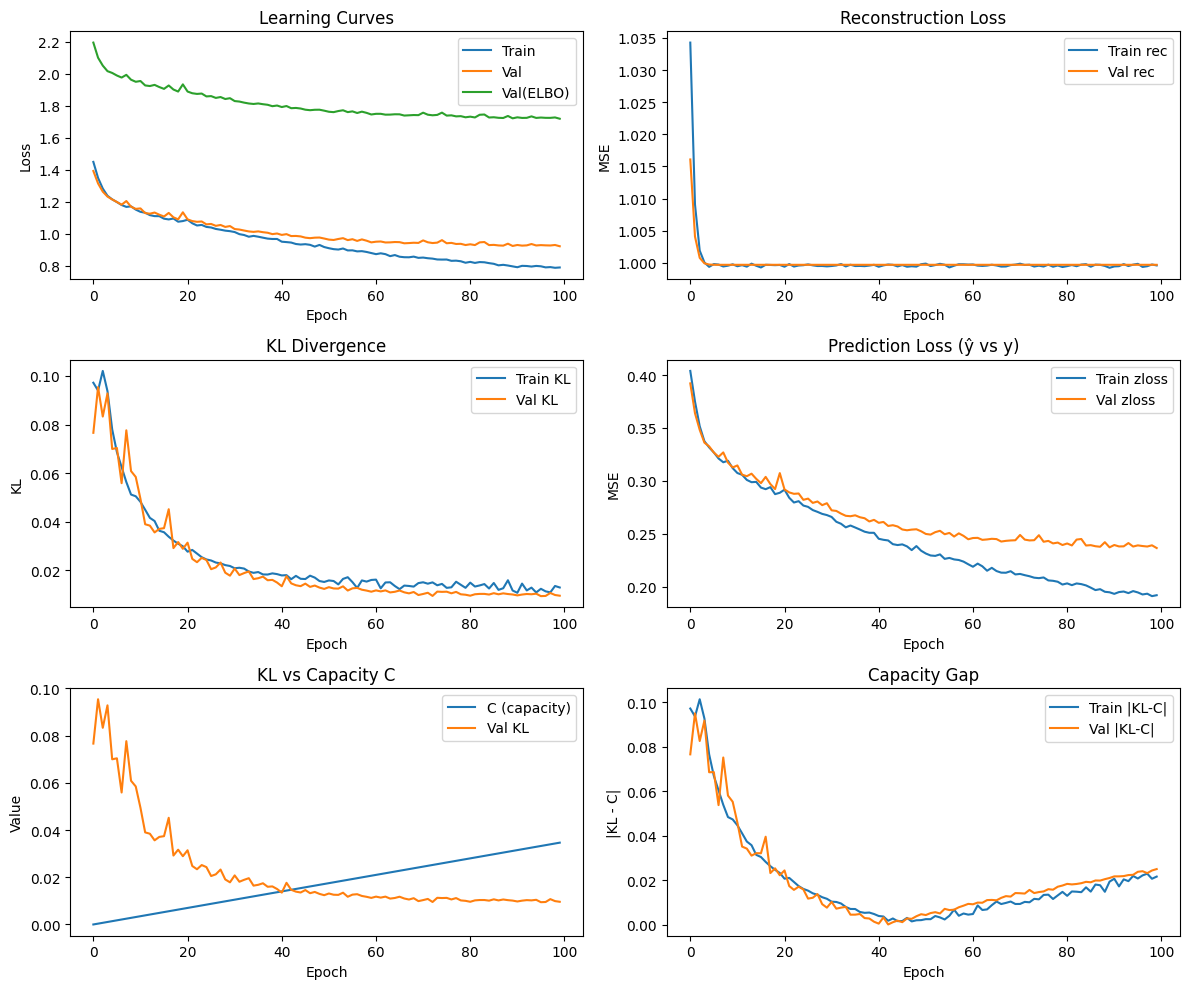

In [17]:
plot_all_curves(
    train_hist,
    val_hist,
    elbo_val_hist,
    train_rec_hist,
    val_rec_hist,
    train_kl_hist,
    val_kl_hist,
    train_z_hist,
    val_z_hist,
    C_values,
    train_capgap_hist,
    val_capgap_hist,
)

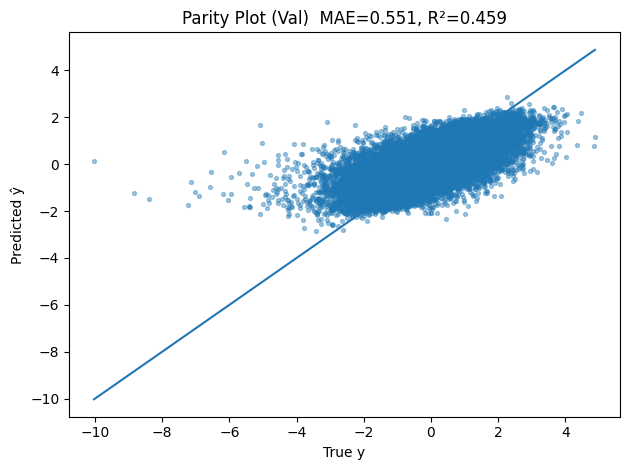

In [18]:
state = torch.load(best_path, map_location=device)
model.load_state_dict(state)
model.eval()  # 評価モード

eval_dl = torch.utils.data.DataLoader(
    val_ds,  # 元の val_ds でOK
    batch_size=8192,  # 好きなサイズ
    shuffle=False,
    num_workers=0,  # ★シングルプロセス
    pin_memory=False,  # ★不要
    persistent_workers=False,  # ★絶対 False
    drop_last=False,
)

ys, yhats = [], []
with torch.inference_mode():
    for xg, xd, y in eval_dl:
        xg, xd = xg.to(device), xd.to(device)
        _, _, _, yhat = model(xg, xd)
        ys.append(y.cpu().numpy())
        yhats.append(yhat.cpu().numpy())
ys = np.concatenate(ys)
yhats = np.concatenate(yhats)
mae = mean_absolute_error(ys, yhats)
r2 = r2_score(ys, yhats)

plt.figure()
plt.scatter(ys, yhats, s=8, alpha=0.4)
lims = [min(ys.min(), yhats.min()), max(ys.max(), yhats.max())]
plt.plot(lims, lims)
plt.xlabel("True y")
plt.ylabel("Predicted ŷ")
plt.title(f"Parity Plot (Val)  MAE={mae:.3f}, R²={r2:.3f}")
plt.tight_layout()
plt.show()

# How to eval from loading the model

In [19]:
# # 1. Build the model and load the trained weights
# model = GeneDrugVAE(gene_dim, drug_dim=768, proj_dim=256, hidden=512, latent=128).to(device)
# model.load_state_dict(torch.load("models/gdsc/gdsc_last.pt", map_location=device))
# model.eval()  # set to evaluation mode

# # 2. Extract latent representations (μ) for all samples
# mus = []
# with torch.no_grad():  # disable gradient computation
#     for xg, xd, _ in dl:   # ignore y (IC50), only need xg and xd
#         xg = xg.to(device, non_blocking=True)
#         xd = xd.to(device, non_blocking=True)
#         mu, lv = model.encode(xg, xd)   # encode gene + drug into latent space
#         mus.append(mu.cpu().numpy())    # collect μ on CPU

# # Concatenate all latent vectors into one array
# Z_mu = np.concatenate(mus, axis=0)
# print("Latent shape:", Z_mu.shape)

In [20]:
# # ---------- 1) 全サンプルの μ をバッチで抽出 ----------
# model.eval()
# mus = []
# with torch.no_grad():
#     # 推論用 DataLoader（shuffle=False）
#     infer_dl = DataLoader(ds, batch_size=8192, shuffle=False, num_workers=0)
#     for xg, xd, y in tqdm(infer_dl, desc="Encode (μ)", leave=False):
#         xg = xg.to(device, non_blocking=True)
#         xd = xd.to(device, non_blocking=True)
#         mu, logvar = model.encode(xg, xd)  # GeneDrugVAE で encode を実装している前提
#         mus.append(mu.cpu().numpy())

# Z_mu = np.concatenate(mus, axis=0)  # (N, latent)

In [21]:
# # 可視化用メタ：薬ラベル & Z_score（元の ds に対応する順序を確保）
# # cellline_small の順序が ds と一致している前提（Dataset 内でそのまま index を使っている実装ならOK）
# meta_df = cellline_small.reset_index(drop=True).copy()
# # NAME が無い場合は SMILES を代用
# drug_label = meta_df["NAME"] if "NAME" in meta_df.columns else meta_df["SMILES"]
# zscore = meta_df["Z_score"].values
# cellline = meta_df["COSMIC_ID"]

In [22]:
# X0 = StandardScaler(with_mean=True, with_std=True).fit_transform(Z_mu)
# X = (
#     PCA(n_components=min(100, X0.shape[1]), random_state=42)
#     .fit_transform(X0)
#     .astype("float32")
# )

# umap2d = umap.UMAP(
#     n_neighbors=40,
#     min_dist=0.05,
#     metric="cosine",
#     init="spectral",
#     densmap=True,
#     random_state=42,
#     low_memory=True,
#     verbose=True,
# ).fit_transform(X)

In [23]:
# plt.figure()
# sc = plt.scatter(umap2d[:, 0], umap2d[:, 1], s=6, c=zscore, alpha=0.7)
# cb = plt.colorbar(sc)
# cb.set_label("Z_score")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.title("UMAP colored by Z_score")
# plt.tight_layout()
# plt.show()

In [24]:
# # 入力: umap2d (N,2), drug_label (N,), zscore (N,)
# labs = pd.Series(drug_label).astype(str).str.strip().values
# z = np.asarray(zscore, dtype=float)

# # 座標で集約（丸めて同一点判定）
# xy = np.round(umap2d, 6)
# df = pd.DataFrame({"x": xy[:, 0], "y": xy[:, 1], "drug": labs, "z": z})

# # 各座標で「z が最小の薬」を代表に採用（効きが強い薬）
# idx = df.groupby(["x", "y"])["z"].idxmin()
# rep = df.loc[idx].reset_index(drop=True)  # x,y,drug,z が 1行/座標

# # 可視化（Top-20 + Other）
# vc = rep["drug"].value_counts()
# top_k = 20
# top = list(vc.head(top_k).index)

# cmap = plt.colormaps.get_cmap("tab20")
# colors = {d: cmap(i / (top_k - 1)) for i, d in enumerate(top)}
# other_color = (0.5, 0.5, 0.5, 0.25)

# plt.figure(figsize=(9, 7))
# # Otherを下地に
# m_other = ~rep["drug"].isin(top)
# plt.scatter(
#     rep.loc[m_other, "x"],
#     rep.loc[m_other, "y"],
#     s=6,
#     alpha=0.30,
#     color=other_color,
#     rasterized=True,
#     zorder=1,
#     label="Other",
#     edgecolors="none",
# )
# # Top-20 を重ねる
# for d in top:
#     m = rep["drug"].values == d
#     if m.any():
#         plt.scatter(
#             rep.loc[m, "x"],
#             rep.loc[m, "y"],
#             s=12,
#             alpha=0.95,
#             color=colors[d],
#             label=d,
#             rasterized=True,
#             zorder=3,
#             edgecolors="none",
#         )

# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.title("UMAP – winner-takes-all by drug (min Z_score)")
# plt.legend(
#     bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8, frameon=False, ncol=2
# )
# plt.tight_layout()
# plt.show()

In [25]:
# labs = pd.Series(drug_label).astype(str).str.strip().values
# drug = "Cisplatin"  # 例

# m = labs == drug
# plt.figure(figsize=(7, 6))
# plt.hexbin(umap2d[m, 0], umap2d[m, 1], gridsize=80, mincnt=1, norm=LogNorm())
# cb = plt.colorbar()
# cb.set_label("count (log)")
# plt.title(f"UMAP density – {drug}")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.tight_layout()
# plt.show()